### 3-variable Lotka-Volterra equation
$$
\frac{dX_i}{dt} = X_i (\gamma_i + \sum_j \alpha_{ij} X_j) 
$$
For $X=\{I,Z,E\}$, intensities of ion-scale turbulence, ion-scale zonal flows, electron-scale turbulence, resprectively,
$$
\frac{dI}{dt} = I (a_0 - a_1 I - a_2 Z - a_3 E)
$$
$$
\frac{dZ}{dt} = Z (-b_0 + b_1 I - b_2 Z - b_3 E)
$$
$$
\frac{dE}{dt} = E (c_0 - c_1 I - c_2 Z - c_3 E)
$$
where all $a_i$, $b_i$, $c_i$ are assumed to be positive.

- Ion-scale turbulence and electron-scale turbulence are linearly unstable ($a_0>0, c_0>0$).  
- Zonal flow is linearly stable ($-b_0<0$) and nonlinearly driven by ion-scale turbulence ($b_1 I Z>0$).
- Cross-scale coupling $a_3, b_3, c_1, c_2$ are mutually exclusive.

solve_Lotka_Volterra_E_sat_sim assumes
$$
E = \max [0, (c_0 - c_1 I - c_2 Z)/c_3 ]
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from solve_Lotka_Volterra import solve_Lotka_Volterra, \
                                 sat_I_with_given_E, sat_Z_with_given_E, sat_E_with_given_I_Z, \
                                 sat_I_ratio_with_given_a3E_b3E, sat_Z_ratio_with_given_a3E_b3E, \
                                 equilibrium_IZE, dIdt_dZdt_with_sat_E, dIdt_dZdt_wo_E
from time import time as timer

import numpy as np
from numba import jit

# matA[0,:] =  a0, -a1, -a2, -a3
# matA[1,:] = -b0,  b1, -b2, -b3
# matA[2,:] =  c0, -c1, -c2, -c3

@jit(nopython=True)
def calc_derivative_E_sat_sim(var,matA,nvar):
    I, Z, _ = var
    _, c1, c2, c3 = -matA[2,:]
    c0 = matA[2,0]
    E = (c0-c1*I-c2*Z)/c3
    if E < 0:
        E=0
    wvar = np.zeros_like(var)
    wvar[0]=I
    wvar[1]=Z
    wvar[2]=E
    dvardt = np.zeros_like(var)
    for i in range(nvar):
        dvardt[i] = wvar[i] * (matA[i,0] + np.sum(matA[i,1:]*wvar[:]))
    return dvardt
    
@jit(nopython=True)
def kernel_solve_Lotka_Volterra_E_sat_sim(var_list,matA,dt,nt,nvar):
    var = var_list[0,:].copy()
    for it in range(nt-1):
        wvar = var.copy()
        k1 = calc_derivative_E_sat_sim(wvar,matA,nvar)
        wvar = var + 0.5*dt*k1
        k2 = calc_derivative_E_sat_sim(wvar,matA,nvar)
        wvar = var + 0.5*dt*k2
        k3 = calc_derivative_E_sat_sim(wvar,matA,nvar)
        wvar = var + dt*k3
        k4 = calc_derivative_E_sat_sim(wvar,matA,nvar)
        var = var + (dt/6.0)*(k1+2*k2+2*k3+k4)
        I, Z, _ = var
        _, c1, c2, c3 = -matA[2,:]
        c0 = matA[2,0]
        E = (c0-c1*I-c2*Z)/c3
        if E < 0:
            E=0
        var[2] = E
        var_list[it+1,:] = var[:].copy()
    return var_list
    
def solve_Lotka_Volterra_E_sat_sim(matA,dt,nt,var0):
    nvar, _ = matA.shape
    var_list = np.zeros([nt,nvar])
    # Initial values
    var_list[0,:] = var0[:].copy()
    # Time integration
    var_list = kernel_solve_Lotka_Volterra_E_sat_sim(var_list,matA,dt,nt,nvar)
    # Output
    time = dt * np.arange(nt)
    return time, var_list




matA=np.array([[0.1, -0.01, -0.25, -0.5],
               [-0.1, 0.5, -0.01, -0.1],
               [20.0, -10.0, -2.0, -200.0]])
matA_wo_cross = matA.copy()
matA_wo_cross[0,3] = 0.0
matA_wo_cross[1,3] = 0.0
matA_wo_cross[2,1:3] = 0.0

dt = 0.001
nt = 4000001

t1 = timer()
var0 = np.array([1e-3,1e-3,1e-3]) # Initial values
time, var = solve_Lotka_Volterra(matA,dt,nt,var0)
time, var_wo_cross = solve_Lotka_Volterra(matA_wo_cross,dt,nt,var0)
time, var_E_sat_sim = solve_Lotka_Volterra_E_sat_sim(matA,dt,nt,var0)
t2 = timer(); print(t2-t1)

12.560177564620972


[[ 0.          0.          0.        ]
 [ 0.          0.          0.1       ]
 [10.          0.          0.        ]
 [ 0.20783373  0.39168665  0.        ]
 [ 0.22170078  0.21765515  0.08673841]]


/home/smaeyama/mylib/Miniconda3/envs/lab/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


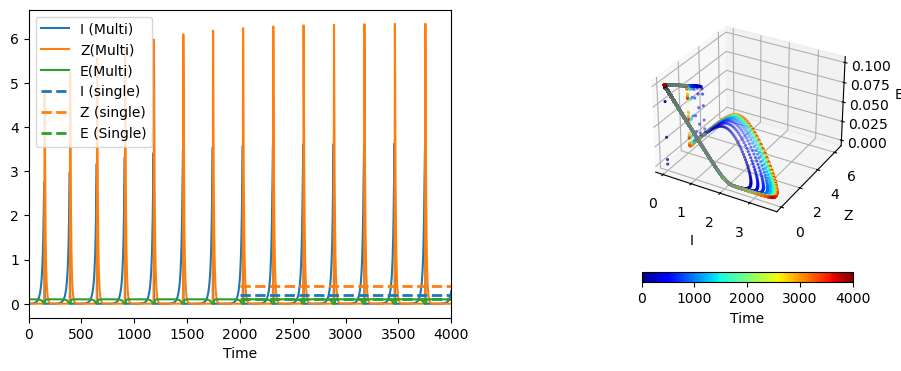

[[ 0.          0.          0.        ]
 [ 0.          0.          0.1       ]
 [10.          0.          0.        ]
 [ 0.20783373  0.39168665  0.        ]
 [ 0.22170078  0.21765515  0.08673841]]


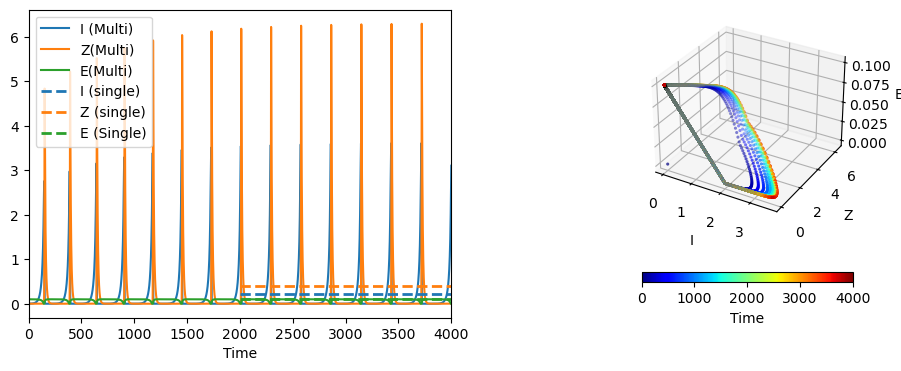

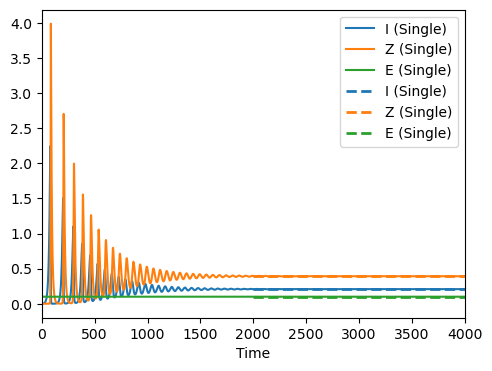

In [2]:
_, a1, a2, a3 = -matA[0,:]
b0, _, b2, b3 = -matA[1,:]
_, c1, c2, c3 = -matA[2,:]
a0 = matA[0,0]
b1 = matA[1,1]
c0 = matA[2,0]

%matplotlib inline
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(time,var)
ax.axhline(sat_I_with_given_E(matA,0.0),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C0")
ax.axhline(sat_Z_with_given_E(matA,0.0),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C1")
ax.axhline(matA[2,0]/(-matA[2,3]),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C2")
ax.legend(["I (Multi)","Z(Multi)","E(Multi)","I (single)","Z (single)", "E (Single)"])
ax.set_xlim(time[0],time[-1])
ax.set_xlabel("Time")

equilibrium = equilibrium_IZE(matA)
print(equilibrium)
ax = fig.add_subplot(1,2,2,projection="3d")
ista=0
iend=int(nt)
iskp=100
quad = ax.scatter(var[ista:iend:iskp,0],var[ista:iend:iskp,1],var[ista:iend:iskp,2],c=time[ista:iend:iskp],cmap="jet",marker=".",lw=0)
# ax.scatter(equilibrium[:,0],equilibrium[:,1],equilibrium[:,2],marker="s",c="k")
# wI = np.linspace(0,var[:,0].max(),400)
# wZ = np.linspace(0,var[:,0:2].max(),420)
# wI2,wZ2 = np.meshgrid(wI,wZ)
# ax.plot_wireframe(wI2,wZ2,sat_E_with_given_I_Z(matA,wI2,wZ2),rstride=20,cstride=20,lw=0.3)
ax.set_xlabel("I")
ax.set_ylabel("Z")
ax.set_zlabel("E")
# ax.set_xlim(0,None)
# ax.set_ylim(0,None)
# ax.set_zlim(0,None)
plt.colorbar(quad,shrink=0.5,label="Time",orientation="horizontal")

plt.show()

### E=E_sat model
%matplotlib inline
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(time,var_E_sat_sim)
ax.axhline(sat_I_with_given_E(matA,0.0),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C0")
ax.axhline(sat_Z_with_given_E(matA,0.0),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C1")
ax.axhline(matA[2,0]/(-matA[2,3]),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C2")
ax.legend(["I (Multi)","Z(Multi)","E(Multi)","I (single)","Z (single)", "E (Single)"])
ax.set_xlim(time[0],time[-1])
ax.set_xlabel("Time")

equilibrium = equilibrium_IZE(matA)
print(equilibrium)
ax = fig.add_subplot(1,2,2,projection="3d")
ista=0
iend=int(nt)
iskp=100
quad = ax.scatter(var_E_sat_sim[ista:iend:iskp,0],var_E_sat_sim[ista:iend:iskp,1],var_E_sat_sim[ista:iend:iskp,2],c=time[ista:iend:iskp],cmap="jet",marker=".",lw=0)
# ax.scatter(equilibrium[:,0],equilibrium[:,1],equilibrium[:,2],marker="s",c="k")
# wI = np.linspace(0,var[:,0].max(),400)
# wZ = np.linspace(0,var[:,0:2].max(),420)
# wI2,wZ2 = np.meshgrid(wI,wZ)
# ax.plot_wireframe(wI2,wZ2,sat_E_with_given_I_Z(matA,wI2,wZ2),rstride=20,cstride=20,lw=0.3)
ax.set_xlabel("I")
ax.set_ylabel("Z")
ax.set_zlabel("E")
# ax.set_xlim(0,None)
# ax.set_ylim(0,None)
# ax.set_zlim(0,None)
plt.colorbar(quad,shrink=0.5,label="Time",orientation="horizontal")

plt.show()

# Check single scale
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(time,var_wo_cross)
ax.axhline(sat_I_with_given_E(matA,0.0),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C0")
ax.axhline(sat_Z_with_given_E(matA,0.0),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C1")
ax.axhline(matA[2,0]/(-matA[2,3]),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C2")
ax.legend(["I (Single)","Z (Single)","E (Single)","I (Single)","Z (Single)", "E (Single)"])
ax.set_xlim(time[0],time[-1])
ax.set_xlabel("Time")
plt.show()

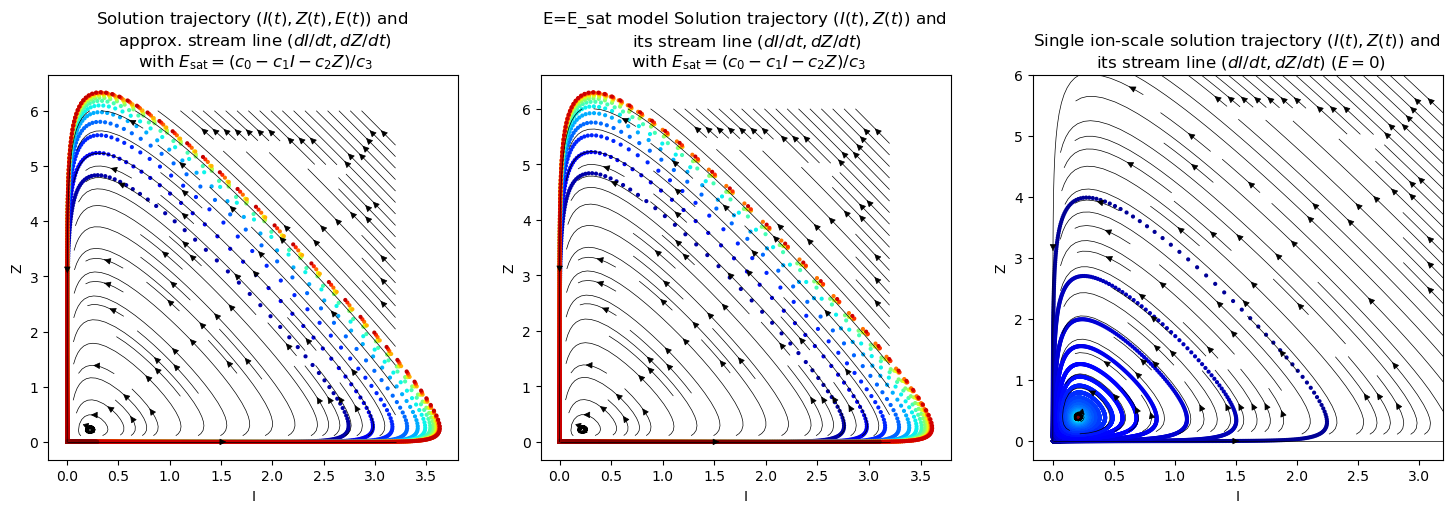

In [3]:
grid_I = np.linspace(0,3.2,200)
grid_Z = np.linspace(0,6,180)
I2, Z2 = np.meshgrid(grid_I, grid_Z)
dIdt, dZdt = dIdt_dZdt_with_sat_E(matA,I2,Z2)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(label="Solution trajectory $(I(t),Z(t), E(t))$ and \n"
             +" approx. stream line $(dI/dt,dZ/dt)$ \n"
             +" with $E_\mathrm{sat}=(c_0-c_1I-c_2Z)/c_3$")
ax.streamplot(I2, Z2, dIdt, dZdt, linewidth=0.5, color="k")
ax.scatter(var[:iend:iskp,0],var[:iend:iskp,1],c=time[:iend:iskp],cmap="jet",marker=".",lw=0)
ax.set_xlabel("I")
ax.set_ylabel("Z")
ax = fig.add_subplot(1,3,2)
ax.set_title(label="E=E_sat model Solution trajectory $(I(t),Z(t))$ and \n"
             +" its stream line $(dI/dt,dZ/dt)$ \n"
             +" with $E_\mathrm{sat}=(c_0-c_1I-c_2Z)/c_3$")
ax.streamplot(I2, Z2, dIdt, dZdt, linewidth=0.5, color="k")
ax.scatter(var_E_sat_sim[:iend:iskp,0],var_E_sat_sim[:iend:iskp,1],c=time[:iend:iskp],cmap="jet",marker=".",lw=0)
ax.set_xlabel("I")
ax.set_ylabel("Z")
ax = fig.add_subplot(1,3,3)
ax.set_title(label="Single ion-scale solution trajectory $(I(t),Z(t))$ and \n"
             +" its stream line $(dI/dt,dZ/dt)$ ($E=0$)")
dIdt0, dZdt0 = dIdt_dZdt_wo_E(matA,I2,Z2)
ax.streamplot(I2, Z2, dIdt0, dZdt0, linewidth=0.5, color="k")
ax.scatter(var_wo_cross[:iend:iskp,0],var_wo_cross[:iend:iskp,1],c=time[:iend:iskp],cmap="jet",marker=".",lw=0)
ax.set_xlabel("I")
ax.set_ylabel("Z")
plt.show()
plt.show()

In [4]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ista=int(0.6*nt)
iend=int(nt)
iskp=100
quad = ax.scatter(var[ista:iend:iskp,0],var[ista:iend:iskp,1],var[ista:iend:iskp,2],c=time[ista:iend:iskp],cmap="jet",marker=".",lw=0)
ax.scatter(equilibrium[:,0],equilibrium[:,1],equilibrium[:,2],marker="s",c="k")
wI = np.linspace(0,var[:,0].max(),400)
wZ = np.linspace(0,var[:,0:2].max(),420)
wI2,wZ2 = np.meshgrid(wI,wZ)
ax.plot_wireframe(wI2,wZ2,sat_E_with_given_I_Z(matA,wI2,wZ2),rstride=20,cstride=20,lw=0.3)
ax.set_xlabel("I")
ax.set_ylabel("Z")
ax.set_zlabel("E")
ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.set_zlim(0,None)
fig.colorbar(quad,shrink=0.5,label="Time")
plt.show()

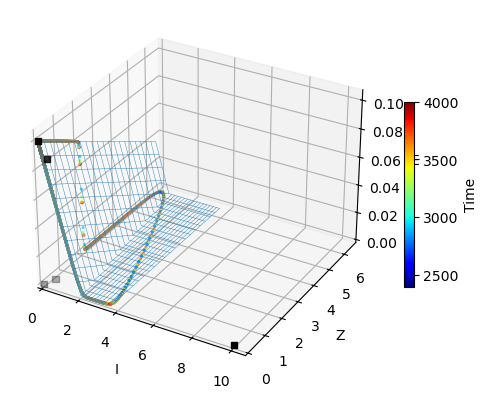

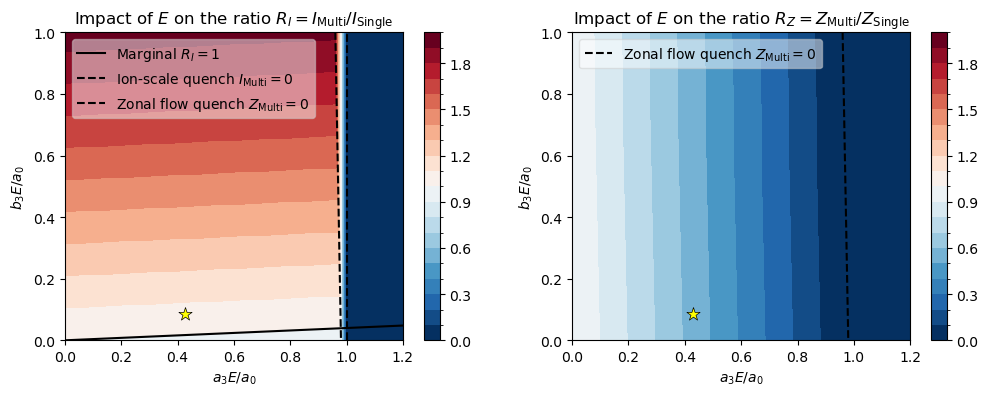

In [5]:
%matplotlib inline

cmap = plt.cm.RdBu_r  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
bounds = np.linspace(0,2,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


a3Emax = 1.2
b3Emax = 1.0
normalized_a3E = np.linspace(0,a3Emax,400)
normalized_b3E = np.linspace(0,b3Emax,420)
a3E,b3E = np.meshgrid(normalized_a3E,normalized_b3E)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.set_title(r"Impact of $E$ on the ratio $R_I = I_\mathrm{Multi}/I_\mathrm{Single}$")
quad = ax.pcolormesh(a3E,b3E,sat_I_ratio_with_given_a3E_b3E(matA,a3E*a0,b3E*a0),cmap=cmap,norm=norm)
ax.plot(normalized_a3E,b2/a2*normalized_a3E,label=r"Marginal $R_I=1$",c="k")
ax.axvline(a0/a0,label=r"Ion-scale quench $I_\mathrm{Multi}=0$",c="k",linestyle="dashed")
ax.plot(normalized_a3E,(-b0+(a0-(normalized_a3E*a0))*b1/a1)/a0,label=r"Zonal flow quench $Z_\mathrm{Multi}=0$",c="k",linestyle="dashed")
ax.scatter(a3*var[-1,2]/a0,b3*var[-1,2]/a0,s=100,marker="*",c="yellow",edgecolors="k",lw=0.5)
ax.set_xlabel(r"$a_3 E / a_0$")
ax.set_ylabel(r"$b_3 E / a_0$")
ax.set_xlim(0,a3Emax)
ax.set_ylim(0,b3Emax)
ax.legend(loc="upper left",framealpha=0.5)
fig.colorbar(quad)
(a0-a3E)*b1/a1-(b0+b3E)<0
ax = fig.add_subplot(1,2,2)
ax.set_title(r"Impact of $E$ on the ratio $R_Z = Z_\mathrm{Multi}/Z_\mathrm{Single}$")
quad = ax.pcolormesh(a3E,b3E,sat_Z_ratio_with_given_a3E_b3E(matA,a3E*a0,b3E*a0),cmap=cmap,norm=norm)
ax.plot(normalized_a3E,(-b0*(1+a2*b1/(a1*b2))+b1*(a0/a1+a2*b0/(a1*b2))-b1*normalized_a3E*a0/a1)/a0,label=r"Zonal flow quench $Z_\mathrm{Multi}=0$",c="k",linestyle="dashed")
ax.scatter(a3*var[-1,2]/a0,b3*var[-1,2]/a0,s=100,marker="*",c="yellow",edgecolors="k",lw=0.5)
ax.set_xlabel(r"$a_3 E / a_0$")
ax.set_ylabel(r"$b_3 E / a_0$")
ax.set_xlim(0,a3Emax)
ax.set_ylim(0,b3Emax)
ax.legend(loc="upper left",framealpha=0.5)
fig.colorbar(quad)
plt.show()

In [6]:
print(matA)

[[ 1.0e-01 -1.0e-02 -2.5e-01 -5.0e-01]
 [-1.0e-01  5.0e-01 -1.0e-02 -1.0e-01]
 [ 2.0e+01 -1.0e+01 -2.0e+00 -2.0e+02]]


In [7]:
print(matA[0:2,0:3])

E_sat_correction = np.array(
                   [[-a3*c0/c3, a3*c1/c3, a3*c2/c3],
                    [-b3*c0/c3, b3*c1/c3, b3*c2/c3]])
print(E_sat_correction)
print(matA[0:2,0:3]+E_sat_correction)

[[ 0.1  -0.01 -0.25]
 [-0.1   0.5  -0.01]]
[[-0.05   0.025  0.005]
 [-0.01   0.005  0.001]]
[[ 0.05   0.015 -0.245]
 [-0.11   0.505 -0.009]]
